### Collate FEA Results, Perform EDA & Construct Final ABT (Dataset)
Analyses were run off in 50 'buckets' of 1,000 (load cases).  This was done to enable the analsyes to be run in parallel across several machines. Timetraces for 6 parameters were generated for each analysis. These timetraces were post-processed to get the max range for each parameter.  A summary dataframe for each bucket (1,000 files) is stored in the analysis results sub-folder.  We now need to combine the 50 separate dataframes to make a single results file.  This will then be joined with the analysis input dataset to form the final abt dataset.

In [160]:
import os
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import ntpath # Equivalent of R's base (remove path)
import glob as gb

In [161]:
fo_p = '/Users/jasonpayne/Documents/my_repos/slug_spools/analysis_results/'
res_files = gb.glob(f'{fo_p}*.csv')

In [162]:
# Loop through each separate results (bucket) file and combine to one file
c = 1
for res_file in res_files:
    df = pd.read_csv(f'{res_file}')
    if c == 1:
        res_df = df
    else:    
        res_df = pd.concat([res_df, df], ignore_index=True)
    c += 1

In [163]:
# Sort by load case number and reset the index
res_df.sort_values(by=['load_case'], inplace=True)
res_df.reset_index(inplace=True, drop=True)

In [164]:
# Print a statistical summary of the result data
res_df.describe()

,out_oopDisp_mm_n2,out_supReac_kN_n3,out_supReac_kN_n4,out_verDisp_mm_n5,out_oopDisp_mm_n5,out_endBend_kNm_n6
count,43983.000000,43983.000000,43983.000000,43983.000000,43983.000000,43983.000000
mean,182.064175,15.739671,52.697170,233.564503,187.254900,218.339169
std,30.869636,1.879557,6.462091,42.873464,44.123468,58.950122
min,73.240000,8.970000,24.300000,103.100000,74.360000,89.470000
25%,162.650000,14.470000,48.790000,204.170000,161.040000,177.340000
50%,179.800000,15.510000,53.170000,228.820000,180.400000,209.180000
75%,198.150000,16.730000,56.940000,257.225000,203.675000,247.550000
max,497.920000,36.330000,89.490000,578.030000,711.910000,700.150000


In [165]:
# Utility function for creating basic data quality report for numeric data
def generate_dq_num(dat, cols):
    data_types = pd.DataFrame(dat.dtypes, columns=['Data Type'])
    missing_data = pd.DataFrame(dat.isnull().sum(), columns=['Missing Values'])
    unique_values = pd.DataFrame(columns=['Unique Values'])
    max_values = pd.DataFrame(columns=['Max Value'])
    min_values = pd.DataFrame(columns=['Min Value'])
    mean_values = pd.DataFrame(columns=['Mean Value'])
    median_values = pd.DataFrame(columns=['Median Value'])
    for row in list(cols.values):
        unique_values.loc[row] = [dat[row].nunique()]    
        min_values.loc[row] = [dat[row].min()]
        mean_values.loc[row] = [dat[row].mean()]
        median_values.loc[row] = [dat[row].median()]
        max_values.loc[row] = [dat[row].max()]    
    dq_report = data_types.join(missing_data).join(unique_values).join(min_values).\
        join(mean_values).join(median_values).join(max_values)
    return(dq_report)

In [166]:
# Print a standard data quality report
generate_dq_num(res_df.drop(['load_case'], axis=1), res_df.columns.drop(['load_case']))

,Data Type,Missing Values,Unique Values,Min Value,Mean Value,Median Value,Max Value
out_oopDisp_mm_n2,float64,0,11951,73.24,182.064175,179.80,497.92
out_supReac_kN_n3,float64,0,1317,8.97,15.739671,15.51,36.33
out_supReac_kN_n4,float64,0,3666,24.30,52.697170,53.17,89.49
out_verDisp_mm_n5,float64,0,15560,103.10,233.564503,228.82,578.03
out_oopDisp_mm_n5,float64,0,14000,74.36,187.254900,180.40,711.91
out_endBend_kNm_n6,float64,0,18096,89.47,218.339169,209.18,700.15


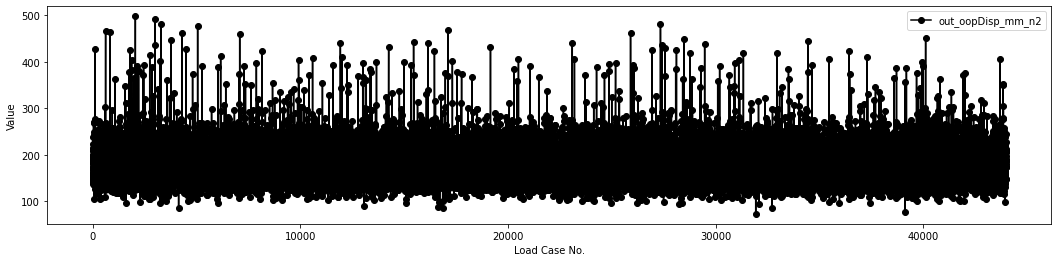

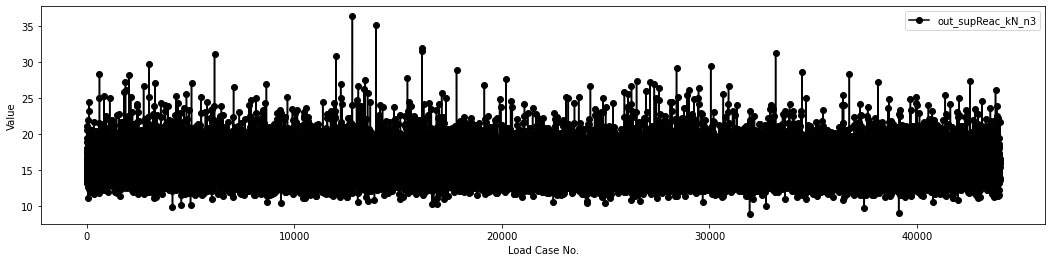

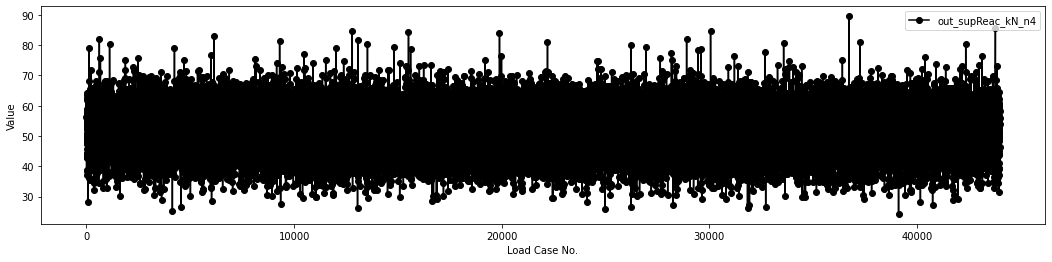

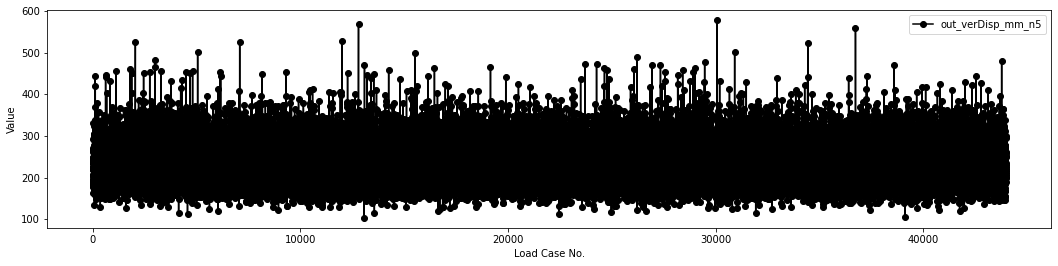

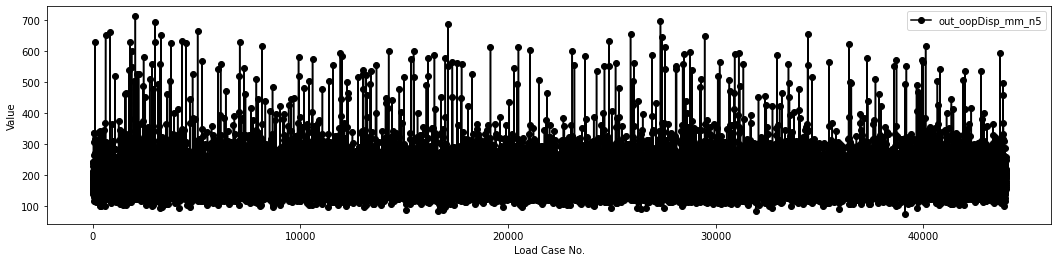

In [167]:
# Plot each result for each load case
for chan in res_df.columns[1:-1]:
    fig, ax = plt.subplots(figsize = (18, 4))
    ax.plot(res_df[chan], color = 'black', marker = 'o', zorder = 1, label = chan)
    ax.legend(loc = 'upper right')
    plt.xlabel('Load Case No.')
    plt.ylabel('Value')
plt.show()

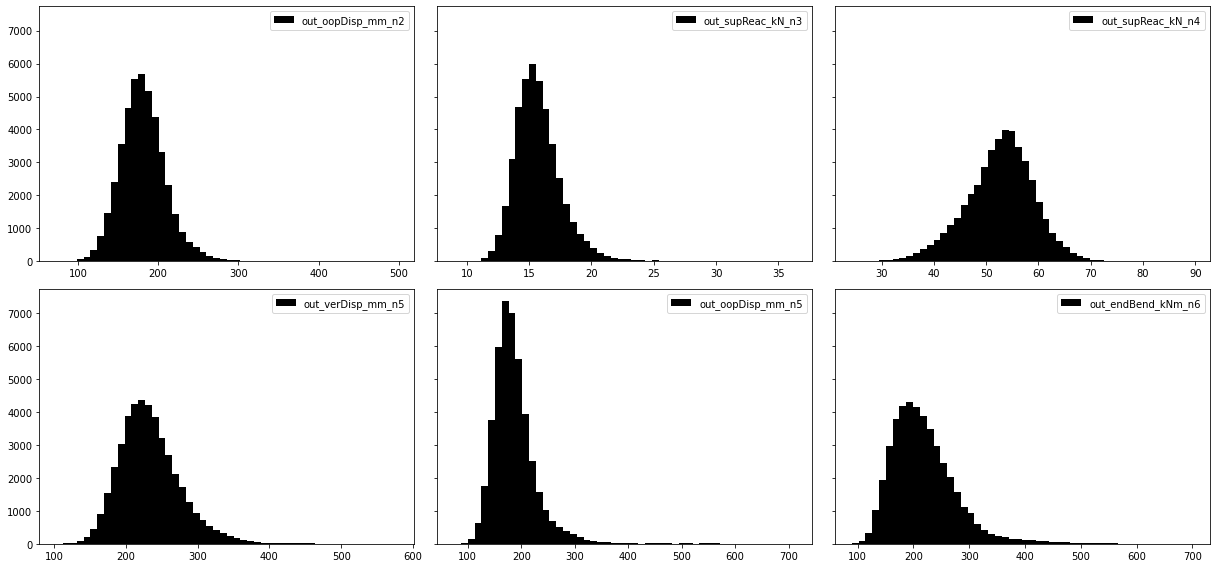

In [168]:
# Plot distributions of each result parameter
n_bins = 50
fig, axs = plt.subplots(2, 3, sharey=True, tight_layout=True, figsize = (17, 8))
axs = axs.ravel()
drops = ['load_case']
for p, ref in enumerate(res_df.columns.drop(drops)):
    axs[p].hist(res_df[ref].values, bins=n_bins, label = ref, color = 'black')
    axs[p].legend(loc = 'upper right')

In [149]:
# Read the analysis inputs file
abt_df = pd.read_csv('220304_abt.csv')

In [150]:
# Add simulation time as a feature (may be useful)
SLUG_COUNT = 12
abt_df['simTime'] = round(1 + SLUG_COUNT*(abt_df.slugLen/abt_df.slugVel + abt_df.pockLen/abt_df.slugVel) + (60/abt_df.slugVel), 1)
abt_df

,loadCase,slugDen,slugLen,pockDen,pockLen,slugVel,basePer,baseAmp,basePha,simTime
0,00001_sd786_sl6_pd234_pl10_sv6_bp13_ba850_bp74...,785.67,6.47,234.16,10.06,5.77,12.55,0.85,74.10,45.8
1,00002_sd705_sl10_pd190_pl11_sv7_bp12_ba800_bp5...,705.03,10.36,190.44,11.25,7.42,11.63,0.80,59.11,44.0
2,00003_sd742_sl12_pd159_pl13_sv7_bp12_ba650_bp6...,741.98,11.64,159.09,12.52,7.42,11.54,0.65,65.23,48.2
3,00004_sd732_sl9_pd168_pl10_sv10_bp11_ba670_bp6...,731.88,8.82,167.88,9.84,9.52,11.48,0.67,67.85,30.8
4,00005_sd669_sl11_pd214_pl9_sv8_bp13_ba810_bp57...,669.21,11.46,213.87,8.56,8.18,12.86,0.81,56.68,37.7
...,...,...,...,...,...,...,...,...,...,...
49995,49996_sd732_sl9_pd173_pl10_sv9_bp13_ba620_bp59...,732.32,9.06,172.68,9.95,8.89,12.78,0.62,59.34,33.4
49996,49997_sd793_sl11_pd189_pl10_sv7_bp11_ba660_bp8...,793.21,11.41,189.05,10.24,7.15,10.96,0.66,80.89,45.7
49997,49998_sd621_sl12_pd173_pl9_sv4_bp12_ba720_bp65...,620.52,11.60,173.32,9.37,4.03,12.21,0.72,65.25,78.3
49998,49999_sd704_sl8_pd214_pl12_sv11_bp10_ba640_bp6...,704.16,8.17,214.00,11.90,11.39,9.95,0.64,65.80,27.4


In [151]:
# Change the name of the load case field so that it is consitent between files
# and we can use a left join (on load case)
res_df = res_df.rename(columns={"load_case":"loadCase"})

In [152]:
# Remove the file extension from the abt file
# Again for consistency between files
abt_df.loadCase = abt_df.loadCase.apply(lambda x: x[:len(x) - 6])

In [153]:
# Perform left join to complete the final dataset
dataset = abt_df.merge(res_df, on='loadCase', how='left')
dataset

,loadCase,slugDen,slugLen,pockDen,pockLen,slugVel,basePer,baseAmp,basePha,simTime,out_oopDisp_mm_n2,out_supReac_kN_n3,out_supReac_kN_n4,out_verDisp_mm_n5,out_oopDisp_mm_n5,out_endBend_kNm_n6
0,00001_sd786_sl6_pd234_pl10_sv6_bp13_ba850_bp74,785.67,6.47,234.16,10.06,5.77,12.55,0.85,74.10,45.8,197.45,16.22,56.42,248.24,180.47,198.49
1,00002_sd705_sl10_pd190_pl11_sv7_bp12_ba800_bp59,705.03,10.36,190.44,11.25,7.42,11.63,0.80,59.11,44.0,186.85,15.97,58.86,262.33,178.72,238.07
2,00003_sd742_sl12_pd159_pl13_sv7_bp12_ba650_bp65,741.98,11.64,159.09,12.52,7.42,11.54,0.65,65.23,48.2,155.47,14.29,48.63,220.89,163.53,180.64
3,00004_sd732_sl9_pd168_pl10_sv10_bp11_ba670_bp68,731.88,8.82,167.88,9.84,9.52,11.48,0.67,67.85,30.8,169.47,15.18,48.72,188.47,163.76,233.31
4,00005_sd669_sl11_pd214_pl9_sv8_bp13_ba810_bp57,669.21,11.46,213.87,8.56,8.18,12.86,0.81,56.68,37.7,223.64,16.90,58.51,271.74,242.37,219.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49996_sd732_sl9_pd173_pl10_sv9_bp13_ba620_bp59,732.32,9.06,172.68,9.95,8.89,12.78,0.62,59.34,33.4,NaN,NaN,NaN,NaN,NaN,NaN
49996,49997_sd793_sl11_pd189_pl10_sv7_bp11_ba660_bp81,793.21,11.41,189.05,10.24,7.15,10.96,0.66,80.89,45.7,NaN,NaN,NaN,NaN,NaN,NaN
49997,49998_sd621_sl12_pd173_pl9_sv4_bp12_ba720_bp65,620.52,11.60,173.32,9.37,4.03,12.21,0.72,65.25,78.3,NaN,NaN,NaN,NaN,NaN,NaN
49998,49999_sd704_sl8_pd214_pl12_sv11_bp10_ba640_bp66,704.16,8.17,214.00,11.90,11.39,9.95,0.64,65.80,27.4,NaN,NaN,NaN,NaN,NaN,NaN


In [159]:
# Verify some of the larger simulation times
# Get load case number & review the FEA animation
dataset.simTime[dataset.simTime > 250]

1748     339.7
2757     357.7
3716     346.0
10260    652.0
14276    251.2
17322    253.9
18619    285.7
19718    253.9
24605    279.8
24857    884.8
24936    273.9
26446    408.4
29144    492.4
41168    330.4
42507    324.2
43407    258.7
Name: simTime, dtype: float64

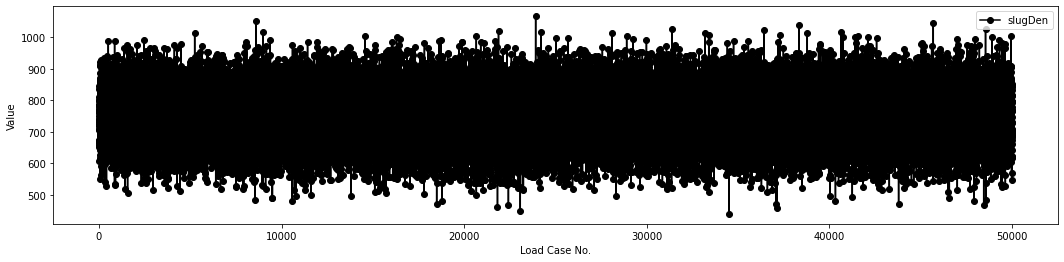

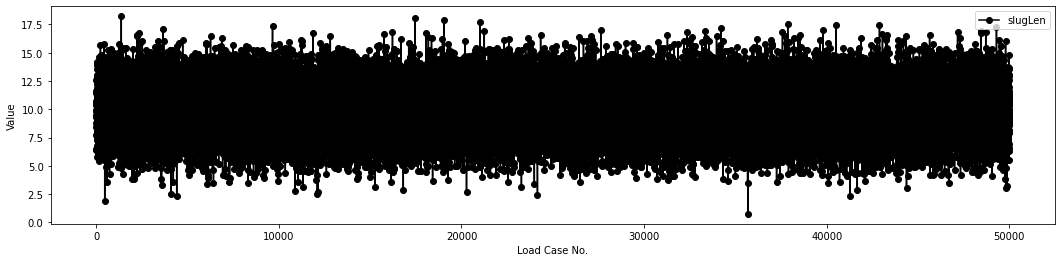

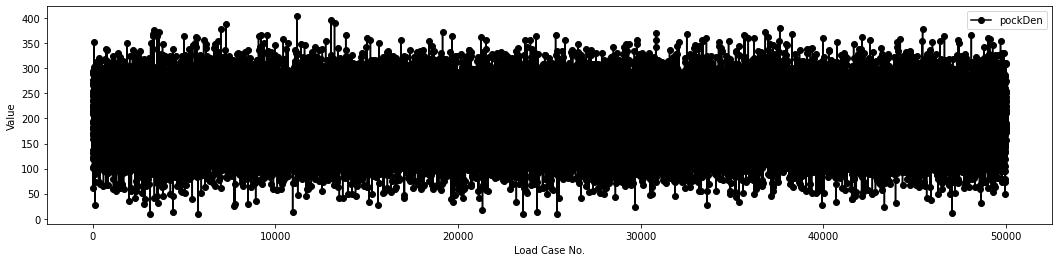

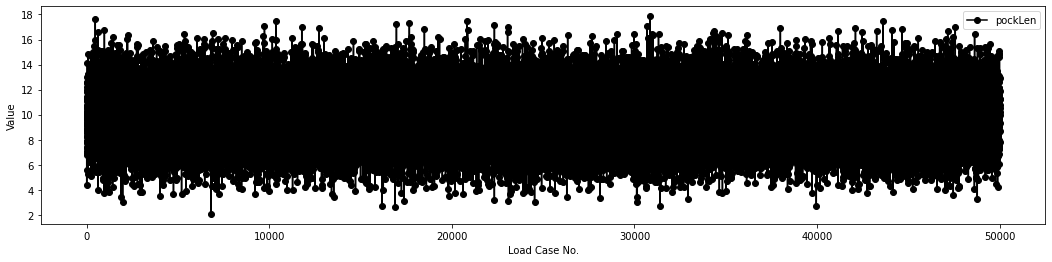

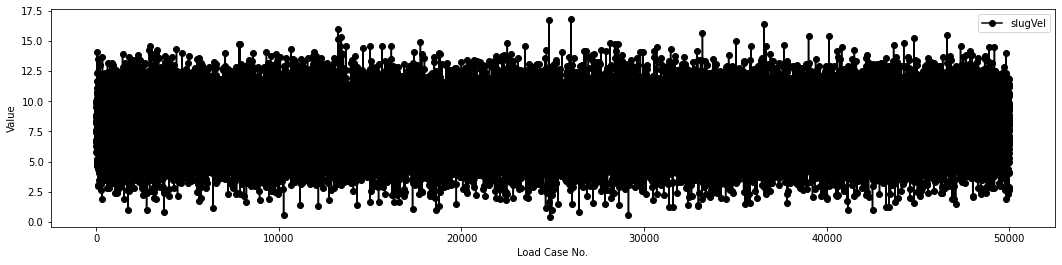

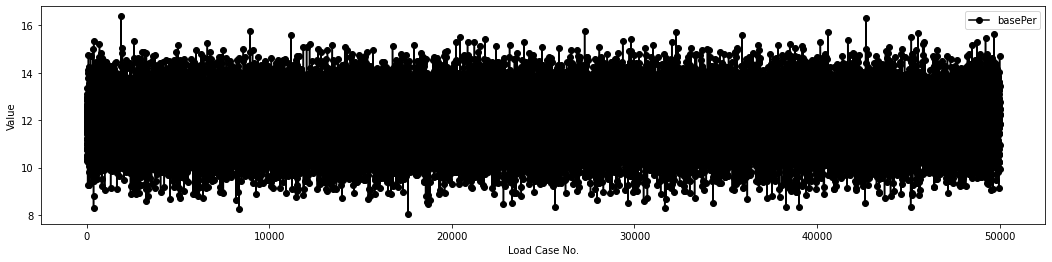

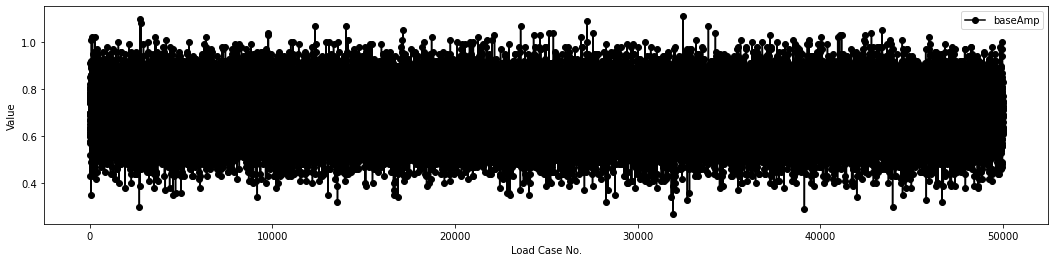

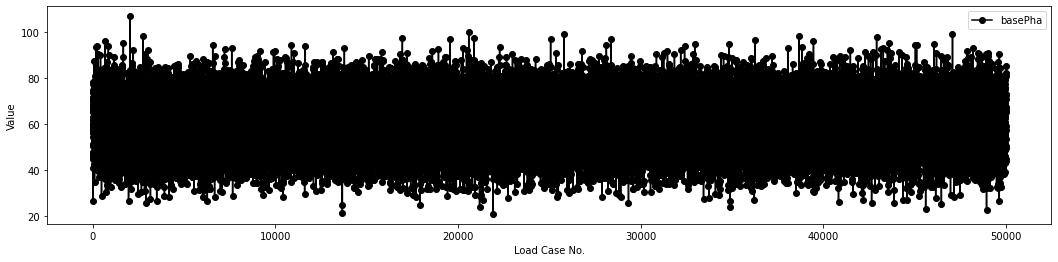

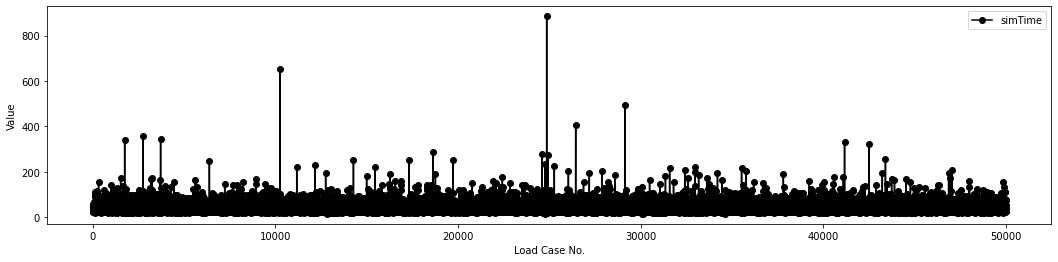

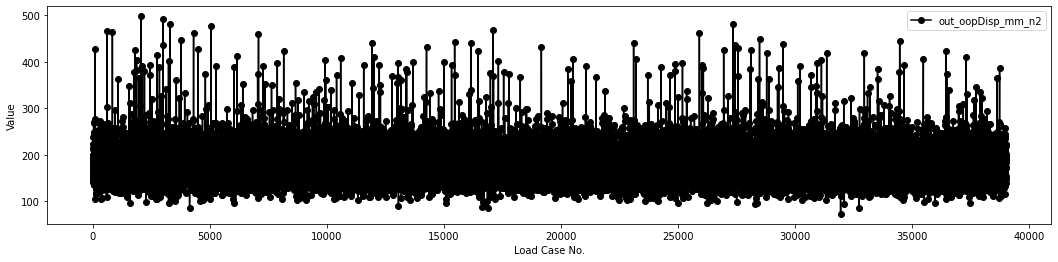

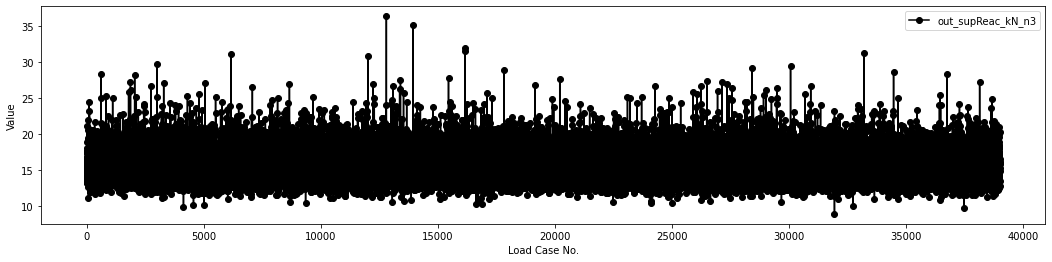

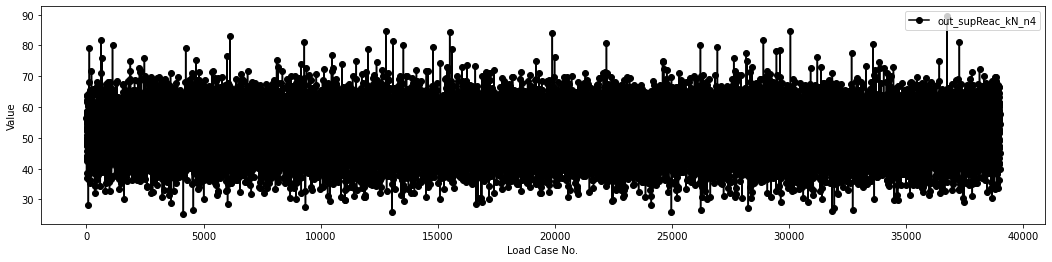

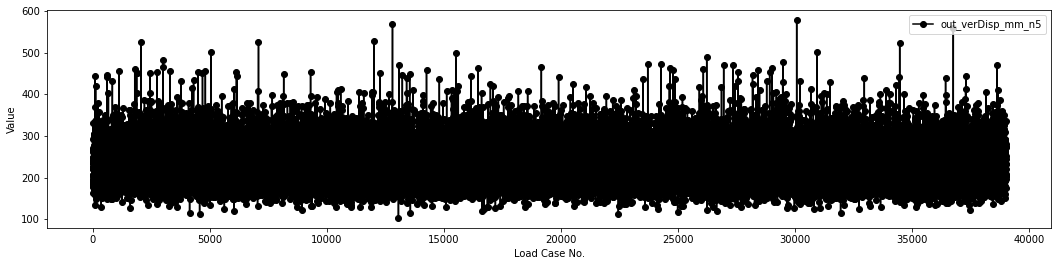

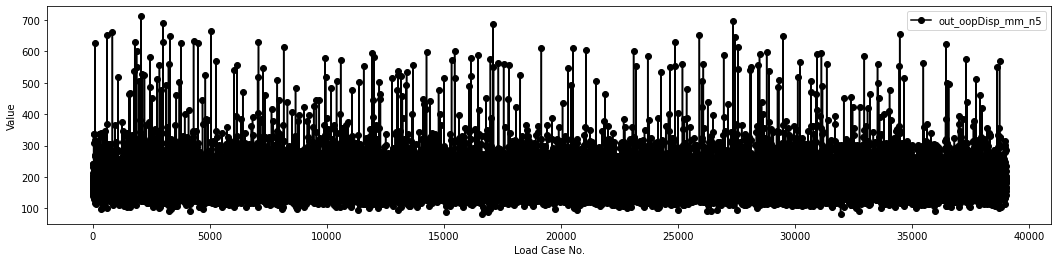

In [154]:
# Plot each result for each load case
for chan in dataset.columns[1:-1]:
    fig, ax = plt.subplots(figsize = (18, 4))
    ax.plot(dataset[chan], color = 'black', marker = 'o', zorder = 1, label = chan)
    ax.legend(loc = 'upper right')
    plt.xlabel('Load Case No.')
    plt.ylabel('Value')
plt.show()